In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import os
import fnmatch
from torch.utils.data import Dataset
from PIL import Image
from patch_functions import *
from loss_functions import *
from dataset_functions import *
import torch
import torch.optim as optim
import shutil 

In [9]:
# Transforming from PIL to Tensor
transform1 = transforms.ToTensor()

# Transforming from Tensor to PIL
transform2 = transforms.ToPILImage()

In [8]:
%%capture
# Model: con queste due righe di codice è possibile definire il modello 
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#### Labels for the training

In [10]:
%%capture
# Define the model without the autoshape = False 
model_lab = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom
model_lab.to(device)

In [7]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
images = [f for f in os.listdir(images_path) if f.endswith('.png')]

for image in images:
    # I consider the txt file path 
    img_path = images_path + '/' + image
    # Get the results 
    results = model_lab(img_path)
    # Trasform the yolo labels into a numpy array to save them
    array = results.xywhn[0].cpu().numpy()
    # Select only the object that are people
    array = array[array[:,-1] == 0]
    # Classes in the first column 
    permutation = [1, 2, 3, 4, 5, 0]
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    array[:] = array[:, idx]
    # Remove the last column
    array = array[:,:-1]
    # Save the array 
    np.savetxt(images_path + '/yolo-labels/' + image[0:-4] + '.txt', array)

In [10]:
img_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos/person_and_bike_033.png'
results = model_lab(img_path)
# Trasform the yolo labels into a numpy array to save them
array = results.xywhn[0].cpu().numpy()
# Select only the object that are people
array = array[array[:,-1] == 0]
# Classes in the first column 
permutation = [1, 2, 3, 4, 5, 0]
idx = np.empty_like(permutation)
idx[permutation] = np.arange(len(permutation))
array[:] = array[:, idx]
print(array)
array = array[:,:-1]
print(array)

[[          0     0.81328     0.39023     0.10938     0.30078     0.87842]]
[[          0     0.81328     0.39023     0.10938     0.30078]]


In [1]:
# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/inria/INRIAPerson/Train/pos')
print(len(list)-1)

# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/inria/INRIAPerson/Train/pos/yolo-labels')
print(len(list))

# The two quantities of elements match

614
614


### Isolate all the image with a most 2 people

In [17]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
images = [f for f in os.listdir(images_path) if f.endswith('.png')]

for image in images:
    # I consider the txt file path 
    img_path = images_path + '/' + image
    destination = '/home/andread98/yolov3/dataset/' + image
    # Get the results 
    results = model_lab(img_path)
    # Trasform the yolo labels into a numpy array to save them
    array = results.xywhn[0].cpu().numpy()
    # Select only the object that are people
    array = array[array[:,-1] == 0]
    # Classes in the first column 
    permutation = [1, 2, 3, 4, 5, 0]
    idx = np.empty_like(permutation)
    idx[permutation] = np.arange(len(permutation))
    array[:] = array[:, idx]
    # Remove the last column
    array = array[:,:-1]
    if array.shape[0] <= 2:
        # Save the array 
        np.savetxt('/home/andread98/yolov3/dataset/yolo-labels/' + image[0:-4] + '.txt', array)
        # Save a copy of the image in the right folder
        shutil.copy(img_path, destination)
    

In [18]:
# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/dataset')
print(len(list)-1)

# Number of images in the training set

list = os.listdir('/home/andread98/yolov3/dataset/yolo-labels')
print(len(list))

# The two quantities of elements match

133
133


### Difference between model() and model().eval()

In [ ]:
# Define the device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# create the image
image = torch.rand((1,3,640,640))
image = image.to(device)

# model without eval
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom

output = model(image)
print(output)

# model with eval
model = model.eval()
output = model(image)
print(output)

#They are different, I should use the eval. We don't want to train the network
#But the parameters of the patch!

### VOC dataset

In [70]:
# Importing the dataset and convert the images to tensors 

training_data = datasets.VOCDetection(
    root= "data",
    year = "2007",
    download = False,
    transform = ToTensor()
)


In [71]:
batch_size = 1

train_loader = torch.utils.data.DataLoader(
                training_data,
                batch_size=batch_size,
                shuffle=True,
                num_workers=8)

### What is the output of the network?

In [16]:
img_dir = "/home/andread98/yolov3/inria/INRIAPerson/Train/pos"
batch_size = 6
img_size=640

# Create the train_loader that will be used for the training routine 
# Setting the batch and the image directory

train_loader_2 = torch.utils.data.DataLoader(
                InriaDataset(img_dir, img_size, shuffle=True),
                batch_size=batch_size,
                shuffle=True)

In [6]:
for i, data in enumerate(train_loader_2):
    image = data
    break

In [7]:
%%capture
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom
model.cuda()

In [8]:
for i, data in enumerate(train_loader_2):
    image = data.cuda()
    print(image.dtype)
    outputs = model(image)
    print('Len output: ',len(outputs))
    print(outputs[0].shape)
    print(outputs[1][0].shape)
    print(outputs[1][1].shape)
    print(outputs[1][2].shape)
    if i==0:
        break

torch.float32
Len output:  2
torch.Size([6, 25200, 85])
torch.Size([6, 3, 80, 80, 85])
torch.Size([6, 3, 40, 40, 85])
torch.Size([6, 3, 20, 20, 85])


In [9]:
batch_dim = outputs[1][0].shape[0]

# Get the propabilities we need from the tensors
yolo_output1 = outputs[1][0]
yolo_output1 = torch.reshape(yolo_output1, (batch_dim,3*80*80,85))

yolo_output2 = outputs[1][1]
yolo_output2 = torch.reshape(yolo_output2, (batch_dim,3*40*40,85))

yolo_output3 = outputs[1][2]
yolo_output3 = torch.reshape(yolo_output3, (batch_dim,3*20*20,85))

final_tensor = torch.cat((yolo_output1,yolo_output2,yolo_output3), dim=1)

In [12]:
cls_id = 0
objectness = final_tensor[:, :, 4]
print(objectness.shape)
max_conf, index = torch.max(objectness, dim=1)
print(index)
cond_prob_targeted_class = final_tensor[:, :, 5 + cls_id]
max_cond_prob_targeted_class = cond_prob_targeted_class[:,index]
print(max_cond_prob_targeted_class)
max, _ = torch.max(max_cond_prob_targeted_class, dim=1)
max


torch.Size([6, 25200])
tensor([24222, 25009, 20223, 24628, 21582, 24621], device='cuda:0')
tensor([[-7.02075, -2.19610, -0.24838, -2.83312, -1.44984, -6.07033],
        [ 4.33518,  6.20039, -1.80158,  2.57108,  0.77897,  2.80105],
        [-0.33135,  0.25989,  4.96177,  4.75610,  4.45325,  0.38139],
        [-7.37270,  2.56614, -0.67330,  5.75325, -2.51057, -3.74810],
        [-4.39590, -2.06937, -1.87788, -3.30874,  5.76501, -5.76826],
        [ 5.81627,  4.60000, -1.24017,  6.24623, -3.54087,  6.56021]], device='cuda:0')


tensor([-0.24838,  6.20039,  4.96177,  5.75325,  5.76501,  6.56021], device='cuda:0')

In [50]:
cls_id = 0
batch_dim = outputs[1][0].shape[0]

# Get the propabilities we need from the tensors
yolo_output1 = outputs[1][0]
yolo_output1 = torch.reshape(yolo_output1, (batch_dim,3*80*80,85)).sigmoid()

yolo_output2 = outputs[1][1]
yolo_output2 = torch.reshape(yolo_output2, (batch_dim,3*40*40,85)).sigmoid()

yolo_output3 = outputs[1][2]
yolo_output3 = torch.reshape(yolo_output3, (batch_dim,3*20*20,85)).sigmoid()

final_tensor = torch.cat((yolo_output1,yolo_output2,yolo_output3), dim=1)

objectness = final_tensor[:, :, 4]
cond_prob_targeted_class = final_tensor[:, :, 5+cls_id]

confs_if_object_normal = objectness*cond_prob_targeted_class

max_conf, _ = torch.max(confs_if_object_normal, dim=1)

max_conf

tensor([0.92130], device='cuda:0')

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image = torch.rand((1,3,640,640))
image = image.to(device)
outputs = model(image)


### How to obtain the first tensor given the others
Note that the coordinates of the BB still don't make sense, I need to understand how to compute them starting form the other outputs. 
But, to define the loss the BB coordinates are not necessary.

In [45]:
# %%capture
final_true = outputs[0]
yolo_output1 = outputs[1][0]
print(torch.reshape(yolo_output1, (1,3*80*80,85))[0,0,:])
yolo_output1 = torch.reshape(yolo_output1, (1,3*80*80,85)).sigmoid()
print(yolo_output1)

yolo_output2 = outputs[1][1]
yolo_output2 = torch.reshape(yolo_output2, (1,3*40*40,85)).sigmoid()

yolo_output3 = outputs[1][2]
yolo_output3 = torch.reshape(yolo_output3, (1,3*20*20,85)).sigmoid()

final_tensor = torch.cat((yolo_output1,yolo_output2,yolo_output3), dim=1)
print(final_true.shape)
final_tensor.shape[0]

tensor([  0.97231,   0.12388,   0.34327,  -0.38789, -12.25723,  -3.23859,  -6.97841,  -5.25728,  -6.79948,  -7.15996,  -7.24253,  -7.53783,  -6.73830,  -6.37754,  -4.50419,  -6.37800,  -5.50886,  -6.77535,  -6.73173,  -4.28813,  -6.93197,  -6.84087,  -6.78025,  -6.29227,  -6.62484,  -6.94971,  -7.39728,  -7.66485,
         -7.53894,  -6.14535,  -4.71841,  -5.66537,  -6.83824,  -6.80403,  -5.81056,  -7.16004,  -6.90741,  -1.94358,  -4.48559,  -7.29603,  -7.08646,  -7.36169,  -6.55336,  -7.25745,  -3.94874,  -5.58981,  -3.89496,  -6.64983,  -6.33828,  -5.52751,  -4.41237,  -4.70032,  -1.01072,  -6.77318,  -1.89668,  -6.13228,
         -4.53293,  -6.20302,  -7.05708,  -5.08217,  -5.53444,  -4.86435,  -7.01460,  -4.04729,  -7.55544,  -6.47353,  -6.95861,  -6.41884,  -7.12364,  -5.74580,  -6.27983,  -7.47586,  -6.33861,  -7.21214,  -7.40816,  -7.57872,  -6.61201,  -6.94611,  -5.58567,  -5.87415,  -4.15872,  -6.38599,  -5.03909,  -7.15184,
         -6.08031], device='cuda:0')
tensor([[[7.255

1

In [25]:
%%capture
print(final_true[0,0,:])
print(final_tensor[0,0,:])
print(torch.reshape(yolo_output1, (1,3*80*80,85)))
# Same probabilities!!
print(final_true[0,0,4:]==final_tensor[0,0,4:])
print(final_true[0,22999,4:]==final_tensor[0,22999,4:])
print(final_true[0,25199,4:]==final_tensor[0,25199,4:])

In [75]:
#This works, so we can use the other tensors to compute the backward step
torch.sum(final_tensor).backward()

## Patch Applier

In [23]:
# Apply the patch in the up left corner of the image
def apply_patch_central(image, patch):
    size = patch.shape[2]
    image[:,:,200:200+size,200:200+size] = patch
    return image

## Training Routine

#### Patch

In [ ]:
model.eval()
patch = torch.full((1, 3, 2, 2), 0.5, requires_grad = True)

loss_function = yolov3_feature_output_manage(0)

optimizer = optim.SGD([patch], lr = 0.03, weight_decay=0.1)

torch.autograd.set_detect_anomaly(True)

for epoch in range(1):  # loop over the dataset multiple times
    for i, data in enumerate(train_loader):
        print(f'Iteration number: {i}')
        # get the inputs; data is a list of [inputs, labels]
        batch_image = data

        # Applying the patch to all the images in the batch 
        batch_att_image = apply_patch_central(batch_image, patch)


        # forward of the model
        outputs = model(batch_att_image)
        loss = torch.mean(loss_function(outputs))
        print(loss)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(patch.grad)
        print(patch.grad.shape)
        print(patch)
        print(patch.shape)
        # Keep the patch in range (0,1)
        patch.data.clamp_(0, 1)
        # patch_PIL = transform2(patch.squeeze(0))
        # patch_PIL.show()

        # # print(patch.grad)
        # # # print statistics
        # # running_loss += loss.item()
        if i == 4:    # print every 20 mini-batches
            # print(f'[{epoch + 1}, {i + 1:5d}] loss: {mean_loss.item():.3f}')
            # running_loss = 0.0
            break

    print('Finished Training')

### Entire image

In [17]:
%%capture
# Selecting the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)
model.to(device)

In [39]:
class apply_patch(nn.Module):
    """
    """

    def __init__(self):
        super(apply_patch, self).__init__()

    def forward(self, patch, image):
        dim = patch.shape[2]
        image[:,:,220:220+dim,220:220+dim] = patch
        return image

In [ ]:
apply_function = apply_patch().to(device)

# Patch definition
patch = torch.full((1, 3, 200, 200), 0.5)
patch = patch.to(device)
patch.requires_grad_(True)

# Black image definition
black_image = torch.zeros((1,3,640,640))
black_image = black_image.to(device)

crop = apply_function(patch, black_image)
crop_PIL = transform2(crop.squeeze(0))
crop_PIL.show()

Try to create a patch applying it in the center of a black image

Iteration number:  0
Max image grad:  tensor(0.04042, device='cuda:0')
Min image grad:  tensor(-0.05354, device='cuda:0')
Max image:  tensor(0.50161, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49879, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(4.98516, device='cuda:0', grad_fn=<MeanBackward0>)
Iteration number:  1
Max image grad:  tensor(0.11285, device='cuda:0')
Min image grad:  tensor(-0.09770, device='cuda:0')
Max image:  tensor(0.50454, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49576, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(4.95706, device='cuda:0', grad_fn=<MeanBackward0>)
Iteration number:  2
Max image grad:  tensor(0.06064, device='cuda:0')
Min image grad:  tensor(-0.07849, device='cuda:0')
Max image:  tensor(0.50391, device='cuda:0', grad_fn=<MaxBackward1>)
Min image:  tensor(0.49617, device='cuda:0', grad_fn=<MinBackward1>)
Loss value:  tensor(5.81877, device='cuda:0', grad_fn=<MeanBackward0>)
Iterati

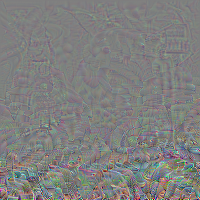

In [43]:
for i in range(5):   
    # Patch definition
    patch = torch.full((1, 3, 100, 100), 0.5)
    patch = patch.to(device)
    patch.requires_grad_(True)

    # Black image definition
    black_image = torch.zeros((1,3,640,640))
    black_image = black_image.to(device)

    # Loss function
    loss_function = new_loss_tprob(i).to(device)

    # Patch applier function
    apply_function = apply_patch().to(device)

    # Optimizer definition
    optimizer = optim.SGD([patch], lr = 0.03)

    # torch.autograd.set_detect_anomaly(True)

    for epoch in range(50000):  # loop over the dataset multiple times
        print('Iteration number: ', epoch)
        
        b_image = black_image.detach().clone()

        # Applying the patch to the black-image
        image = apply_function(patch,b_image)
        
        # forward of the model
        outputs = model(image)
        loss = torch.mean(-loss_function(outputs))
        # print(loss)

        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Max image grad: ',torch.max(patch.grad))
        print('Min image grad: ',torch.min(patch.grad))
        patch.data.clamp_(0, 1)
        print('Max image: ',torch.max(patch))
        print('Min image: ',torch.min(patch))        # Keep the patch in range (0,1)
        print('Loss value: ',loss)
    
    name = '/home/andread98/yolov3/Results/SGD_class' + str(i) + '.pt'
    torch.save(patch, name)

    # image_PIL = transform2(patch.squeeze(0))
    # image_PIL

In [ ]:
# torch.save(tensor_name, 'tensor_name.pt')
# tensor_name = torch.load('tensor_name.pt')

In [19]:
tensor = torch.load('/home/andread98/yolov3/params_results/max_prob_class_0.pt')

In [20]:
tensor

[tensor(0.51851, requires_grad=True),
 tensor([0.41719, 0.58014, 0.44612], requires_grad=True),
 tensor([0.55819, 0.42799, 0.52005], requires_grad=True)]

### Testing the crafted Patch
Let's see if the patch works

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
%%capture
model_test = torch.hub.load('ultralytics/yolov3', 'yolov3')  # or yolov3-spp, yolov3-tiny, custom
model_test.eval()

In [45]:
patch = torch.load('patch.pt')
black = torch.zeros((1,3,640,640))
apply_function = apply_patch()
image = apply_function(patch,black)
image_PIL = transform2(image.squeeze(0))

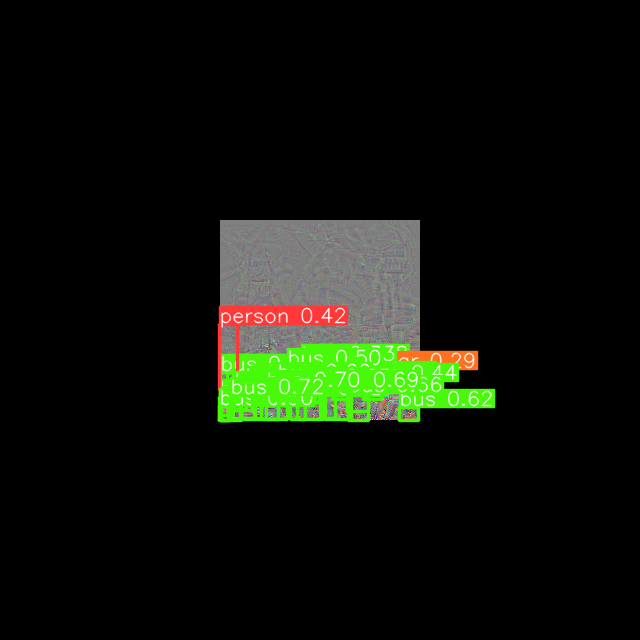

tensor([[0.37930, 0.63711, 0.03945, 0.03750, 0.71680, 5.00000],
        [0.43242, 0.63086, 0.03203, 0.04766, 0.70166, 5.00000],
        [0.52852, 0.63164, 0.04141, 0.04844, 0.68652, 5.00000],
        [0.56055, 0.63633, 0.03125, 0.04219, 0.66260, 5.00000],
        [0.48516, 0.62891, 0.04062, 0.05234, 0.65088, 5.00000],
        [0.63828, 0.64648, 0.02969, 0.02109, 0.62207, 5.00000],
        [0.44531, 0.60938, 0.02422, 0.02969, 0.60107, 5.00000],
        [0.38047, 0.62422, 0.02812, 0.03281, 0.54443, 5.00000],
        [0.41641, 0.63242, 0.03672, 0.04688, 0.53174, 5.00000],
        [0.34961, 0.64648, 0.01328, 0.02187, 0.50488, 5.00000],
        [0.45937, 0.59609, 0.02187, 0.04766, 0.50439, 5.00000],
        [0.36133, 0.64453, 0.03047, 0.02500, 0.46509, 5.00000],
        [0.39443, 0.61406, 0.02129, 0.02812, 0.45630, 5.00000],
        [0.58164, 0.61016, 0.02891, 0.02734, 0.43677, 5.00000],
        [0.35684, 0.55742, 0.02773, 0.10078, 0.42480, 0.00000],
        [0.54453, 0.60273, 0.02344, 0.01

In [46]:
outputs = model_test(image_PIL)
outputs.show()
print(outputs.xywhn[0])

In [144]:
img_dir = "./INRIAPerson/Train/pos"
batch_size = 1
img_size=640

# Create the train_loader that will be used for the training routine 
# Setting the batch and the image directory

test_loader = torch.utils.data.DataLoader(
                InriaDataset(img_dir, img_size, shuffle=True),
                batch_size=batch_size,
                shuffle=True)

In [ ]:
patch = torch.load('big_patch.pt')

for i, data in enumerate(test_loader):
    image = data
    image_PIL = transform2(image.squeeze(0))
    results1 = model_test(image_PIL)
    results1.show()

    att_image = apply_patch(image,patch)
    att_image_PIL = transform2(att_image.squeeze(0))
    results2 = model_test(att_image_PIL)
    results2.show()

    if i == 30:
        break

#### Create the data

In [5]:
import torch
from dataset_functions import *
from patch_functions import *

In [6]:
images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'
labels_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos/yolo-labels'
max_lab = 20
img_size = 614
batch_size = 6



train_loader = torch.utils.data.DataLoader(
                InriaDataset(images_path, labels_path, max_lab, img_size,
                             shuffle=True),
                batch_size=batch_size,
                shuffle=True,
                num_workers=10)

In [7]:
# Definizione dei parametri
a = torch.tensor(0.70)
a.requires_grad_(True)
b = torch.tensor(0.3)
b.requires_grad_(True)
color1 = torch.tensor([1.0,0.0,0.0])
color1.requires_grad_(True)
color2 = torch.tensor([0.0,0.0,1.0])
color2.requires_grad_(True)

params = [a, color1, color2]

gen_function = Fractal_Patch_Generator(20, 300, 3,Tile_Creator_Square,Mask_Creator,2)

gen_function.populate(params)
adv_patch = gen_function.application()
adv_patch.to(device)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0', grad_fn=<ToCopyBackward0>)

In [8]:
adv_patch.shape

torch.Size([3, 300, 300])

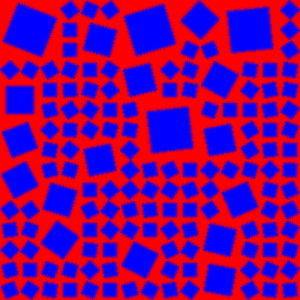

In [9]:
image_PIL = transform2(adv_patch)
image_PIL

In [15]:
adv_patch = torch.ones((3,300,300))

In [10]:
patch_applier = PatchApplier().to(device)
patch_transformer = PatchTransformer().to(device)
img_size = 614

for i_batch, (img_batch, lab_batch) in enumerate(train_loader):
    print(img_batch.shape)
    img_batch = img_batch.to(device)
    lab_batch = lab_batch.to(device)
    adv_patch = adv_patch.to(device)
    # print(lab_batch)
    adv_batch_t = patch_transformer(adv_patch, lab_batch, img_size, do_rotate=True, rand_loc=False)
    p_img_batch = patch_applier(img_batch, adv_batch_t)
    p_img_batch = F.interpolate(p_img_batch, (img_size, img_size))
                            
    if i_batch == 0:
        break

torch.Size([6, 3, 614, 614])


/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [11]:
adv_batch_t.shape

torch.Size([6, 20, 3, 614, 614])

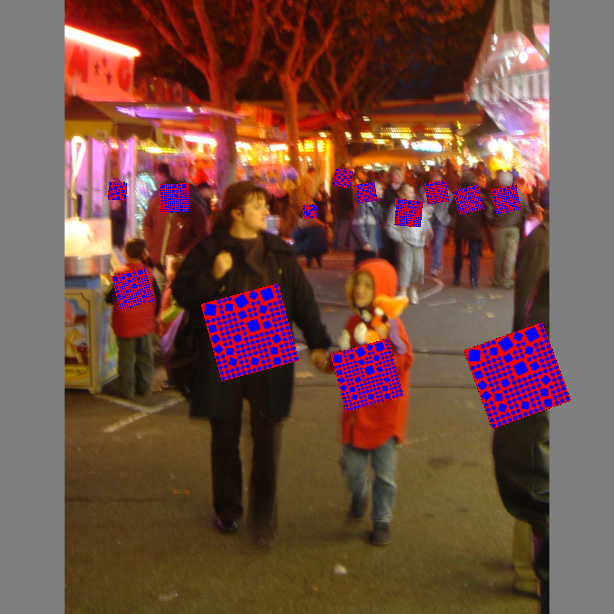

In [13]:
image = p_img_batch[1,:,:,:]

image_PIL = transform2(image)
image_PIL

In [43]:
results = model_lab(image.cpu().detach().numpy())

In [52]:
results = model(torch.ones((1,3,640,640)).to(device))

### Training

In [3]:
use_cuda = 1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model
model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape = False)  # or yolov3-spp, yolov3-tiny, custom

if use_cuda:
    model = model.eval().to(device)  # TODO: Why eval? test!
    patch_applier = PatchApplier().to(device)
    patch_transformer = PatchTransformer().to(device)
    loss_function = max_prob_class2(0).to(device)
    gen_function = Fractal_Patch_Generator(16, 640, 4,Tile_Creator_Square,Mask_Creator,2) # Mettere questo nel configuration file


Using cache found in /home/andread98/.cache/torch/hub/ultralytics_yolov3_master
YOLOv3 🚀 2022-8-7 torch 1.12.1+cu113 CUDA:0 (NVIDIA RTX A5000, 24256MiB)

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients


In [4]:
batch_size = 6    # Mettere questo nel configuration file
n_epochs = 1000   # Mettere questo nel configuration file
max_lab = 30     # Mettere questo nel configuration file
img_size = 640

images_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos'             # Mettere questo nel configuration file
labels_path = '/home/andread98/yolov3/inria/INRIAPerson/Train/pos/yolo-labels' # Mettere questo nel configuration file
train_loader = torch.utils.data.DataLoader(
    InriaDataset(images_path, labels_path, max_lab, img_size,
                    shuffle=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=10)

# Generate a starting point for the parameters
a = torch.tensor(0.70)
a.requires_grad_(True)
b = torch.tensor(0.3)
b.requires_grad_(True)
color1 = torch.tensor([1.0,0.0,0.0])
color1.requires_grad_(True)
color2 = torch.tensor([0.0,0.0,1.0])
color2.requires_grad_(True)

params = [a, color1, color2]

learning_rate = 0.03 # Mettere questo nel configuration file

optimizer = optim.SGD(params, learning_rate)
for epoch in range(n_epochs):
    # ep_det_loss = 0
    # ep_nps_loss = 0
    # ep_tv_loss = 0
    ep_loss = 0
    for i_batch, (img_batch, lab_batch) in enumerate(train_loader):
        gen_function.populate(params)
        adv_patch = gen_function.application()

        if use_cuda:
            img_batch = img_batch.to(device)
            lab_batch = lab_batch.to(device)
            adv_patch = adv_patch.to(device)
        else:
            img_batch = img_batch
            lab_batch = lab_batch
            adv_patch = adv_patch

        adv_batch_t = patch_transformer(adv_patch, lab_batch, img_size, do_rotate=True, rand_loc=False)
        p_img_batch = patch_applier(img_batch, adv_batch_t)
        p_img_batch = F.interpolate(p_img_batch, (img_size, img_size))
        print(p_img_batch)
        #p_img_batch = torch.autograd.Variable(p_img_batch, requires_grad=True)
        # im = transforms.ToPILImage('RGB')(p_img_batch[0])
        # plt.imshow(im)
        # plt.show()

        #CUDA = torch.cuda.is_available()

        output = model(p_img_batch)  # TODO apply YOLOv2 to all (patched) images in the batch (6)
        loss = torch.mean(loss_function(output))
        loss.backward()
        #print("Gradients:\n" + str(torch.autograd.grad(loss, p_img_batch, retain_graph=True, allow_unused=True)))
        #print("Gradients \n"+str(loss.grad))
        optimizer.step()
        optimizer.zero_grad()
        
        params[0].data.clamp_(0, 1)
        params[1].data.clamp_(0, 1)
        params[2].data.clamp_(0, 1)  # keep patch in image range
        print(loss)


/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor([[[[0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          ...,
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804]],

         [[0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          ...,
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804]],

         [[0.49804, 0.49804, 0.49804,  ..., 0.49804, 0.49804, 0.49804],
          [0.49804, 0.49804, 0

KeyboardInterrupt: 

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

from patch_functions import *
from loss_functions import *
from dataset_functions import *
import torch.optim as optim
import patch_config

from torch import autograd
from torchvision import transforms
import time
import os

In [2]:
class PatchTrainer(object):

    def __init__(self, mode, tile):

        # Select the confing file 
        self.config = patch_config.patch_configs[mode]()  # select the mode for the patch

        # Device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Model
        self.model = torch.hub.load('ultralytics/yolov3', 'yolov3', autoshape =False)  # or yolov3-spp, yolov3-tiny, custom

        if use_cuda:
            self.model = self.model.eval().to(self.device)  
            self.patch_applier = PatchApplier().to(self.device)
            self.patch_transformer = PatchTransformer().to(self.device)
            self.loss_function = self.config.loss_function.to(self.device)
            self.gen_function = Fractal_Patch_Generator(self.config.dim_tile, self.config.dim_patch, self.config.mul_fact,self.config.list_function_tile[tile],self.config.mask_function,self.config.rotation_mode) # Mettere questo nel configuration file

        else:
            self.model = self.model  # TODO: Why eval?
            self.patch_applier = PatchApplier()
            self.patch_transformer = PatchTransformer()
            self.loss_function = self.config.loss_function
            self.gen_function = Fractal_Patch_Generator(self.config.dim_tile, self.config.dim_patch, self.config.mul_fact,self.config.list_function_tile[tile],self.config.mask_function,self.config.rotation_mode) # Mettere questo nel configuration file

    def train(self):

        """
        Optimize a patch to generate an adversarial example.
        :return: Nothing
        """

        img_size = self.config.img_size  # 640 for this yolov3

        destination_path = "./"
        destination_name = 'loss_tracking_yv3_ultra_obj_noepoch.txt'
        destination_name2 = 'loss_tracking_compact_batch_yv3_ultra_obj_noepoch.txt'
        destination_name3 = 'loss_tracking_compatc_epochs_yv3_ultra_obj_noepoch.txt'
        destination = os.path.join(destination_path, destination_name)
        destination2 = os.path.join(destination_path, destination_name2)
        destination3 = os.path.join(destination_path, destination_name3)
        textfile = open(destination, 'w+')
        textfile2 = open(destination2, 'w+')
        textfile3 = open(destination3, 'w+')

        # Generate a starting point for the parameters
        a = torch.tensor(0.70)
        a.requires_grad_(True)
        b = torch.tensor(0.3)
        b.requires_grad_(True)
        color1 = torch.tensor([1.0,0.0,0.0])
        color1.requires_grad_(True)
        color2 = torch.tensor([0.0,0.0,1.0])
        color2.requires_grad_(True)

        params = [a, color1, color2]

        train_loader = torch.utils.data.DataLoader(
            InriaDataset(self.config.img_dir, self.config.lab_dir, self.config.max_lab, self.config.img_size,
                            shuffle=True),
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=10)
               # Generate a starting point for the parameters
               
        a = torch.tensor(0.70)
        a.requires_grad_(True)
        b = torch.tensor(0.3)
        b.requires_grad_(True)
        color1 = torch.tensor([1.0,0.0,0.0])
        color1.requires_grad_(True)
        color2 = torch.tensor([0.0,0.0,1.0])
        color2.requires_grad_(True)

        params = [a, color1, color2] 

        self.epoch_length = len(train_loader)
        print(f'One epoch is {len(train_loader)}')

        learning_rate = 0.03 # Mettere questo nel configuration file

        optimizer = optim.SGD(params, learning_rate)  # starting lr = 0.03
        scheduler = self.config.scheduler_factory(optimizer)
        # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50) # write it directly

        n_epochs = self.config.n_epochs

        et0 = time.time()  # epoch start
        for epoch in range(n_epochs):
            ep_loss = 0
            bt0 = time.time()  # batch start
            for i_batch, (img_batch, lab_batch) in tqdm(enumerate(train_loader), desc=f'Running epoch {epoch}',
                                                        total=self.epoch_length):
               
                self.gen_function.populate(params)
                adv_patch = self.gen_function.application()

                if use_cuda:
                    img_batch = img_batch.to(self.device)
                    lab_batch = lab_batch.to(self.device)
                    adv_patch = adv_patch.to(self.device)
                else:
                    img_batch = img_batch
                    lab_batch = lab_batch
                    adv_patch = adv_patch

                adv_batch_t = self.patch_transformer(adv_patch, lab_batch, img_size, do_rotate=True, rand_loc=False)
                p_img_batch = self.patch_applier(img_batch, adv_batch_t)
                p_img_batch = F.interpolate(p_img_batch, (img_size, img_size))
                
                output = self.model(p_img_batch)  # TODO apply YOLOv2 to all (patched) images in the batch (6)
                loss = torch.mean(self.loss_function(output))
                print(loss)
                ep_loss += loss

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                params[0].data.clamp_(0, 1)
                params[1].data.clamp_(0, 1)
                params[2].data.clamp_(0, 1)  # keep patch in image range

                bt1 = time.time()  # batch end
                if i_batch % 1 == 0:
                    print('  BATCH NR: ', i_batch)
                    print('BATCH LOSS: ', loss)
                    print('BATCH TIME: ', bt1 - bt0)

                    # textfile2.write(f'{i_batch} {loss} {det_loss} {nps_loss} {tv_loss}\n')
                    textfile2.write(f'{i_batch} {loss} \n')

                if i_batch + 1 >= len(train_loader):
                    print('\n')
                else:
                    del adv_batch_t, output, p_img_batch, loss

                    if use_cuda:
                        torch.cuda.empty_cache()

                bt0 = time.time()

            et1 = time.time()  # epoch end

            ep_loss = ep_loss / len(train_loader)

            scheduler.step(ep_loss)

            if True:
                print('  EPOCH NR: ', epoch),
                print('EPOCH LOSS: ', ep_loss)
                print('EPOCH TIME: ', et1 - et0)

                textfile.write(f'\ni_epoch: {epoch}\ne_total_loss:{ep_loss}\n\n')
                textfile3.write(f'{ep_loss}\n')

                # Plot the final adv_patch (learned) and save it
                im = transforms.ToPILImage('RGB')(adv_patch)
                plt.imshow(im)
                plt.show()
                im.save("./saved_patches_mytrial/yolov3_ultralytics_obj.png")

                del adv_batch_t, output, p_img_batch, loss

                if use_cuda:
                    torch.cuda.empty_cache()

            et0 = time.time()

In [3]:
use_cuda = 1
mode = 'max_prob_class2'
tile = 0
# 0: Circle 
# 1: Ellipse
# 2: Square 
# 3: Rectangle
# 4: Traingle 
# 5: Trapezoid
trainer = PatchTrainer(mode,tile)
trainer.train()

Using cache found in /home/andread98/.cache/torch/hub/ultralytics_yolov3_master
YOLOv3 🚀 2022-8-7 torch 1.12.1+cu113 CUDA:0 (NVIDIA RTX A5000, 24256MiB)

Fusing layers... 
Model Summary: 261 layers, 61922845 parameters, 0 gradients


One epoch is 103


Running epoch 0:   0%|          | 0/103 [00:00<?, ?it/s]/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4277: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/andread98/yolov3/env/lib/python3.9/site-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


tensor(6.59768, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   1%|          | 1/103 [00:01<02:49,  1.66s/it]

  BATCH NR:  0
BATCH LOSS:  tensor(6.59768, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.108670711517334
tensor(7.26791, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   2%|▏         | 2/103 [00:04<03:40,  2.18s/it]

  BATCH NR:  1
BATCH LOSS:  tensor(7.26791, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.467081069946289
tensor(6.79208, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   3%|▎         | 3/103 [00:05<03:03,  1.84s/it]

  BATCH NR:  2
BATCH LOSS:  tensor(6.79208, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.346733570098877
tensor(6.89333, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   4%|▍         | 4/103 [00:07<03:18,  2.01s/it]

  BATCH NR:  3
BATCH LOSS:  tensor(6.89333, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.185647964477539
tensor(7.05223, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   5%|▍         | 5/103 [00:10<03:34,  2.19s/it]

  BATCH NR:  4
BATCH LOSS:  tensor(7.05223, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.443693161010742
tensor(6.59406, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   6%|▌         | 6/103 [00:12<03:45,  2.32s/it]

  BATCH NR:  5
BATCH LOSS:  tensor(6.59406, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.489824056625366
tensor(6.74303, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   7%|▋         | 7/103 [00:14<03:15,  2.03s/it]

  BATCH NR:  6
BATCH LOSS:  tensor(6.74303, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.3582546710968018
tensor(6.75759, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   8%|▊         | 8/103 [00:16<03:12,  2.03s/it]

  BATCH NR:  7
BATCH LOSS:  tensor(6.75759, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.9456534385681152
tensor(7.04899, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:   9%|▊         | 9/103 [00:18<03:22,  2.15s/it]

  BATCH NR:  8
BATCH LOSS:  tensor(7.04899, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.3415939807891846
tensor(6.88381, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  10%|▉         | 10/103 [00:21<03:39,  2.36s/it]

  BATCH NR:  9
BATCH LOSS:  tensor(6.88381, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7401556968688965
tensor(7.09977, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  11%|█         | 11/103 [00:24<03:42,  2.42s/it]

  BATCH NR:  10
BATCH LOSS:  tensor(7.09977, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.462930917739868
tensor(6.69870, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  12%|█▏        | 12/103 [00:26<03:42,  2.45s/it]

  BATCH NR:  11
BATCH LOSS:  tensor(6.69870, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4363322257995605
tensor(6.47178, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  13%|█▎        | 13/103 [00:29<03:50,  2.56s/it]

  BATCH NR:  12
BATCH LOSS:  tensor(6.47178, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.736631393432617
tensor(6.98233, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  14%|█▎        | 14/103 [00:31<03:23,  2.29s/it]

  BATCH NR:  13
BATCH LOSS:  tensor(6.98233, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.5799922943115234
tensor(6.82074, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  15%|█▍        | 15/103 [00:33<03:18,  2.26s/it]

  BATCH NR:  14
BATCH LOSS:  tensor(6.82074, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.097174882888794
tensor(7.34997, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  16%|█▌        | 16/103 [00:35<03:12,  2.21s/it]

  BATCH NR:  15
BATCH LOSS:  tensor(7.34997, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.032287836074829
tensor(6.84739, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  17%|█▋        | 17/103 [00:38<03:24,  2.38s/it]

  BATCH NR:  16
BATCH LOSS:  tensor(6.84739, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6779117584228516
tensor(7.06053, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  17%|█▋        | 18/103 [00:40<03:25,  2.41s/it]

  BATCH NR:  17
BATCH LOSS:  tensor(7.06053, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4200010299682617
tensor(6.86107, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  18%|█▊        | 19/103 [00:42<02:57,  2.12s/it]

  BATCH NR:  18
BATCH LOSS:  tensor(6.86107, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.353642463684082
tensor(7.43400, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  19%|█▉        | 20/103 [00:44<03:05,  2.23s/it]

  BATCH NR:  19
BATCH LOSS:  tensor(7.43400, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.416862726211548
tensor(6.85891, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  20%|██        | 21/103 [00:47<03:08,  2.30s/it]

  BATCH NR:  20
BATCH LOSS:  tensor(6.85891, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.376307725906372
tensor(6.76153, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  21%|██▏       | 22/103 [00:49<03:14,  2.40s/it]

  BATCH NR:  21
BATCH LOSS:  tensor(6.76153, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5434300899505615
tensor(7.14248, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  22%|██▏       | 23/103 [00:52<03:12,  2.41s/it]

  BATCH NR:  22
BATCH LOSS:  tensor(7.14248, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.3700995445251465
tensor(7.16835, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  23%|██▎       | 24/103 [00:54<03:17,  2.50s/it]

  BATCH NR:  23
BATCH LOSS:  tensor(7.16835, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.635422706604004
tensor(6.89858, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  24%|██▍       | 25/103 [00:57<03:18,  2.54s/it]

  BATCH NR:  24
BATCH LOSS:  tensor(6.89858, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5616729259490967
tensor(6.38699, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  25%|██▌       | 26/103 [01:00<03:25,  2.67s/it]

  BATCH NR:  25
BATCH LOSS:  tensor(6.38699, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.8750112056732178
tensor(6.90548, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  26%|██▌       | 27/103 [01:03<03:23,  2.68s/it]

  BATCH NR:  26
BATCH LOSS:  tensor(6.90548, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6271815299987793
tensor(6.62339, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  27%|██▋       | 28/103 [01:06<03:22,  2.70s/it]

  BATCH NR:  27
BATCH LOSS:  tensor(6.62339, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6631507873535156
tensor(6.81012, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  28%|██▊       | 29/103 [01:08<03:17,  2.66s/it]

  BATCH NR:  28
BATCH LOSS:  tensor(6.81012, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.496591329574585
tensor(6.61592, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  29%|██▉       | 30/103 [01:11<03:22,  2.77s/it]

  BATCH NR:  29
BATCH LOSS:  tensor(6.61592, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.935924768447876
tensor(6.90985, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  30%|███       | 31/103 [01:14<03:18,  2.75s/it]

  BATCH NR:  30
BATCH LOSS:  tensor(6.90985, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.632859945297241
tensor(6.79121, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  31%|███       | 32/103 [01:17<03:17,  2.79s/it]

  BATCH NR:  31
BATCH LOSS:  tensor(6.79121, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.792577028274536
tensor(7.10536, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  32%|███▏      | 33/103 [01:19<03:10,  2.73s/it]

  BATCH NR:  32
BATCH LOSS:  tensor(7.10536, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5052459239959717
tensor(6.85403, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  33%|███▎      | 34/103 [01:22<03:02,  2.65s/it]

  BATCH NR:  33
BATCH LOSS:  tensor(6.85403, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.3855061531066895
tensor(6.54006, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  34%|███▍      | 35/103 [01:24<03:01,  2.67s/it]

  BATCH NR:  34
BATCH LOSS:  tensor(6.54006, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.649521827697754
tensor(7.00661, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  35%|███▍      | 36/103 [01:27<02:59,  2.68s/it]

  BATCH NR:  35
BATCH LOSS:  tensor(7.00661, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6140639781951904
tensor(6.61403, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  36%|███▌      | 37/103 [01:30<02:58,  2.71s/it]

  BATCH NR:  36
BATCH LOSS:  tensor(6.61403, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.689194917678833
tensor(6.79566, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  37%|███▋      | 38/103 [01:33<02:53,  2.67s/it]

  BATCH NR:  37
BATCH LOSS:  tensor(6.79566, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5076587200164795
tensor(6.57324, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  38%|███▊      | 39/103 [01:35<02:47,  2.62s/it]

  BATCH NR:  38
BATCH LOSS:  tensor(6.57324, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.405923366546631
tensor(6.94984, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  39%|███▉      | 40/103 [01:38<02:48,  2.67s/it]

  BATCH NR:  39
BATCH LOSS:  tensor(6.94984, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7078793048858643
tensor(6.49566, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  40%|███▉      | 41/103 [01:40<02:44,  2.66s/it]

  BATCH NR:  40
BATCH LOSS:  tensor(6.49566, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5577847957611084
tensor(6.63972, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  41%|████      | 42/103 [01:43<02:44,  2.69s/it]

  BATCH NR:  41
BATCH LOSS:  tensor(6.63972, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6969690322875977
tensor(7.32588, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  42%|████▏     | 43/103 [01:46<02:41,  2.70s/it]

  BATCH NR:  42
BATCH LOSS:  tensor(7.32588, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.631695508956909
tensor(6.75775, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  43%|████▎     | 44/103 [01:49<02:39,  2.71s/it]

  BATCH NR:  43
BATCH LOSS:  tensor(6.75775, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.64154314994812
tensor(6.76301, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  44%|████▎     | 45/103 [01:51<02:28,  2.56s/it]

  BATCH NR:  44
BATCH LOSS:  tensor(6.76301, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.1415598392486572
tensor(7.05146, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  45%|████▍     | 46/103 [01:54<02:28,  2.61s/it]

  BATCH NR:  45
BATCH LOSS:  tensor(7.05146, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6455979347229004
tensor(6.46848, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  46%|████▌     | 47/103 [01:56<02:25,  2.59s/it]

  BATCH NR:  46
BATCH LOSS:  tensor(6.46848, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4768269062042236
tensor(6.47080, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  47%|████▋     | 48/103 [01:59<02:18,  2.52s/it]

  BATCH NR:  47
BATCH LOSS:  tensor(6.47080, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.262356758117676
tensor(6.89810, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  48%|████▊     | 49/103 [02:01<02:19,  2.58s/it]

  BATCH NR:  48
BATCH LOSS:  tensor(6.89810, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.643433094024658
tensor(7.13238, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  49%|████▊     | 50/103 [02:03<02:00,  2.28s/it]

  BATCH NR:  49
BATCH LOSS:  tensor(7.13238, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.4892244338989258
tensor(6.58879, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  50%|████▉     | 51/103 [02:05<01:56,  2.23s/it]

  BATCH NR:  50
BATCH LOSS:  tensor(6.58879, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.047245502471924
tensor(6.49190, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  50%|█████     | 52/103 [02:08<02:02,  2.40s/it]

  BATCH NR:  51
BATCH LOSS:  tensor(6.49190, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7170333862304688
tensor(6.92121, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  51%|█████▏    | 53/103 [02:10<02:04,  2.49s/it]

  BATCH NR:  52
BATCH LOSS:  tensor(6.92121, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.619424819946289
tensor(6.84768, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  52%|█████▏    | 54/103 [02:14<02:12,  2.69s/it]

  BATCH NR:  53
BATCH LOSS:  tensor(6.84768, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  3.085679054260254
tensor(6.64415, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  53%|█████▎    | 55/103 [02:16<02:08,  2.68s/it]

  BATCH NR:  54
BATCH LOSS:  tensor(6.64415, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.560532331466675
tensor(7.12219, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  54%|█████▍    | 56/103 [02:19<02:04,  2.64s/it]

  BATCH NR:  55
BATCH LOSS:  tensor(7.12219, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4751195907592773
tensor(6.70734, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  55%|█████▌    | 57/103 [02:21<02:00,  2.62s/it]

  BATCH NR:  56
BATCH LOSS:  tensor(6.70734, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.494865894317627
tensor(6.80009, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  56%|█████▋    | 58/103 [02:24<01:56,  2.59s/it]

  BATCH NR:  57
BATCH LOSS:  tensor(6.80009, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.424293279647827
tensor(6.40978, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  57%|█████▋    | 59/103 [02:26<01:41,  2.31s/it]

  BATCH NR:  58
BATCH LOSS:  tensor(6.40978, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.5781149864196777
tensor(7.11543, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  58%|█████▊    | 60/103 [02:28<01:37,  2.26s/it]

  BATCH NR:  59
BATCH LOSS:  tensor(7.11543, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.0592570304870605
tensor(6.86068, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  59%|█████▉    | 61/103 [02:30<01:36,  2.29s/it]

  BATCH NR:  60
BATCH LOSS:  tensor(6.86068, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.29842472076416
tensor(7.04734, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  60%|██████    | 62/103 [02:33<01:37,  2.37s/it]

  BATCH NR:  61
BATCH LOSS:  tensor(7.04734, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4695897102355957
tensor(6.84209, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  61%|██████    | 63/103 [02:35<01:35,  2.39s/it]

  BATCH NR:  62
BATCH LOSS:  tensor(6.84209, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.364403486251831
tensor(6.67982, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  62%|██████▏   | 64/103 [02:38<01:37,  2.50s/it]

  BATCH NR:  63
BATCH LOSS:  tensor(6.67982, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.68123197555542
tensor(6.28977, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  63%|██████▎   | 65/103 [02:41<01:40,  2.66s/it]

  BATCH NR:  64
BATCH LOSS:  tensor(6.28977, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.928675889968872
tensor(6.84666, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  64%|██████▍   | 66/103 [02:44<01:39,  2.69s/it]

  BATCH NR:  65
BATCH LOSS:  tensor(6.84666, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7004480361938477
tensor(6.74332, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  65%|██████▌   | 67/103 [02:46<01:35,  2.65s/it]

  BATCH NR:  66
BATCH LOSS:  tensor(6.74332, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.4691925048828125
tensor(6.76220, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  66%|██████▌   | 68/103 [02:49<01:30,  2.59s/it]

  BATCH NR:  67
BATCH LOSS:  tensor(6.76220, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.377462863922119
tensor(6.52058, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  67%|██████▋   | 69/103 [02:50<01:17,  2.27s/it]

  BATCH NR:  68
BATCH LOSS:  tensor(6.52058, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.4368278980255127
tensor(6.65733, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  68%|██████▊   | 70/103 [02:53<01:20,  2.45s/it]

  BATCH NR:  69
BATCH LOSS:  tensor(6.65733, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7790753841400146
tensor(7.07662, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  69%|██████▉   | 71/103 [02:55<01:13,  2.29s/it]

  BATCH NR:  70
BATCH LOSS:  tensor(7.07662, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.8256261348724365
tensor(7.00690, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  70%|██████▉   | 72/103 [02:57<01:13,  2.38s/it]

  BATCH NR:  71
BATCH LOSS:  tensor(7.00690, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5080442428588867
tensor(6.72563, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  71%|███████   | 73/103 [03:00<01:15,  2.52s/it]

  BATCH NR:  72
BATCH LOSS:  tensor(6.72563, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7858736515045166
tensor(6.68050, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  72%|███████▏  | 74/103 [03:03<01:14,  2.55s/it]

  BATCH NR:  73
BATCH LOSS:  tensor(6.68050, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5461771488189697
tensor(6.43516, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  73%|███████▎  | 75/103 [03:06<01:15,  2.70s/it]

  BATCH NR:  74
BATCH LOSS:  tensor(6.43516, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.9371745586395264
tensor(7.03599, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  74%|███████▍  | 76/103 [03:07<01:02,  2.33s/it]

  BATCH NR:  75
BATCH LOSS:  tensor(7.03599, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.4075279235839844
tensor(6.73348, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  75%|███████▍  | 77/103 [03:09<00:57,  2.23s/it]

  BATCH NR:  76
BATCH LOSS:  tensor(6.73348, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.8967409133911133
tensor(6.47727, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  76%|███████▌  | 78/103 [03:12<00:58,  2.35s/it]

  BATCH NR:  77
BATCH LOSS:  tensor(6.47727, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5717010498046875
tensor(6.63728, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  77%|███████▋  | 79/103 [03:15<00:58,  2.45s/it]

  BATCH NR:  78
BATCH LOSS:  tensor(6.63728, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6089303493499756
tensor(7.11164, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  78%|███████▊  | 80/103 [03:18<00:58,  2.55s/it]

  BATCH NR:  79
BATCH LOSS:  tensor(7.11164, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6898138523101807
tensor(6.88358, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  79%|███████▊  | 81/103 [03:20<00:57,  2.61s/it]

  BATCH NR:  80
BATCH LOSS:  tensor(6.88358, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6699228286743164
tensor(7.34555, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  80%|███████▉  | 82/103 [03:23<00:55,  2.65s/it]

  BATCH NR:  81
BATCH LOSS:  tensor(7.34555, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.653956413269043
tensor(6.43239, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  81%|████████  | 83/103 [03:26<00:54,  2.75s/it]

  BATCH NR:  82
BATCH LOSS:  tensor(6.43239, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.9018139839172363
tensor(6.70022, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  82%|████████▏ | 84/103 [03:29<00:50,  2.67s/it]

  BATCH NR:  83
BATCH LOSS:  tensor(6.70022, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.407231330871582
tensor(6.52141, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  83%|████████▎ | 85/103 [03:31<00:47,  2.65s/it]

  BATCH NR:  84
BATCH LOSS:  tensor(6.52141, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.5271167755126953
tensor(6.71463, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  83%|████████▎ | 86/103 [03:33<00:40,  2.40s/it]

  BATCH NR:  85
BATCH LOSS:  tensor(6.71463, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.725639820098877
tensor(7.14662, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  84%|████████▍ | 87/103 [03:35<00:35,  2.20s/it]

  BATCH NR:  86
BATCH LOSS:  tensor(7.14662, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.6494998931884766
tensor(6.51874, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  85%|████████▌ | 88/103 [03:37<00:35,  2.37s/it]

  BATCH NR:  87
BATCH LOSS:  tensor(6.51874, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.684553861618042
tensor(7.65446, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  86%|████████▋ | 89/103 [03:40<00:35,  2.53s/it]

  BATCH NR:  88
BATCH LOSS:  tensor(7.65446, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.827639102935791
tensor(7.27724, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  87%|████████▋ | 90/103 [03:43<00:34,  2.68s/it]

  BATCH NR:  89
BATCH LOSS:  tensor(7.27724, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.9437575340270996
tensor(6.71231, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  88%|████████▊ | 91/103 [03:46<00:33,  2.76s/it]

  BATCH NR:  90
BATCH LOSS:  tensor(6.71231, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.8491098880767822
tensor(6.38234, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  89%|████████▉ | 92/103 [03:49<00:30,  2.75s/it]

  BATCH NR:  91
BATCH LOSS:  tensor(6.38234, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6681089401245117
tensor(6.77757, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  90%|█████████ | 93/103 [03:51<00:24,  2.42s/it]

  BATCH NR:  92
BATCH LOSS:  tensor(6.77757, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.5657379627227783
tensor(6.92282, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  91%|█████████▏| 94/103 [03:53<00:20,  2.28s/it]

  BATCH NR:  93
BATCH LOSS:  tensor(6.92282, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  1.8766968250274658
tensor(6.78480, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  92%|█████████▏| 95/103 [03:55<00:19,  2.38s/it]

  BATCH NR:  94
BATCH LOSS:  tensor(6.78480, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.515836477279663
tensor(7.12090, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  93%|█████████▎| 96/103 [03:58<00:16,  2.39s/it]

  BATCH NR:  95
BATCH LOSS:  tensor(7.12090, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.33888578414917
tensor(6.50998, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  94%|█████████▍| 97/103 [04:00<00:14,  2.49s/it]

  BATCH NR:  96
BATCH LOSS:  tensor(6.50998, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6478042602539062
tensor(6.64673, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  95%|█████████▌| 98/103 [04:03<00:12,  2.58s/it]

  BATCH NR:  97
BATCH LOSS:  tensor(6.64673, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.689570665359497
tensor(6.78796, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  96%|█████████▌| 99/103 [04:06<00:10,  2.69s/it]

  BATCH NR:  98
BATCH LOSS:  tensor(6.78796, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.889723539352417
tensor(6.36621, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  97%|█████████▋| 100/103 [04:09<00:08,  2.71s/it]

  BATCH NR:  99
BATCH LOSS:  tensor(6.36621, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.6600213050842285
tensor(6.53124, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  98%|█████████▊| 101/103 [04:12<00:05,  2.75s/it]

  BATCH NR:  100
BATCH LOSS:  tensor(6.53124, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7522470951080322
tensor(6.83634, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0:  99%|█████████▉| 102/103 [04:14<00:02,  2.66s/it]

  BATCH NR:  101
BATCH LOSS:  tensor(6.83634, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.381889820098877
tensor(7.22168, device='cuda:0', grad_fn=<MeanBackward0>)


Running epoch 0: 100%|██████████| 103/103 [04:17<00:00,  2.50s/it]

  BATCH NR:  102
BATCH LOSS:  tensor(7.22168, device='cuda:0', grad_fn=<MeanBackward0>)
BATCH TIME:  2.7260022163391113


  EPOCH NR:  0
EPOCH LOSS:  tensor(6.81734, device='cuda:0', grad_fn=<DivBackward0>)
EPOCH TIME:  258.1055197715759


FileNotFoundError: [Errno 2] No such file or directory: './saved_patches_mytrial/yolov3_ultralytics_obj.png'

### Working of the mask, how to create a dataloader with image and mask